### Importing dependences

In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping
from keras.applications import VGG16
from keras import optimizers
import tensorflow as tf

Using TensorFlow backend.


#### Directory paths

In [2]:
train_dir="D:/Docs/Education/Data Science ProDegree Imarticus/Python projects/Analytics Vidya and Kaggle/CatsDogs/train"
valid_dir="D:/Docs/Education/Data Science ProDegree Imarticus/Python projects/Analytics Vidya and Kaggle/CatsDogs/valid"
test_dir="D:/Docs/Education/Data Science ProDegree Imarticus/Python projects/Analytics Vidya and Kaggle/CatsDogs/test/"

### Image Generator

Used for Data Augmentation technique for generating Multiple images from a Single Image.
Images in this generator are generated by:
1. Rotate the image randomly upto 40degs
2. Zooms, Witdth and Height change
3. Horizontal flips etc

We will use separate Valid generator so keep valid data as intact without much modification

In [4]:
train_data_gen=ImageDataGenerator(rescale=1./255,rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                                 shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [5]:
valid_data_gen=ImageDataGenerator(rescale=1./255)

#### Control batch and resolution of the image

In [6]:
res=150
batch=64

#### Train and valid generator data flow from Disk

1. The colour mode is controled by "color_mode" argument, "grayscale" and "rgb",
2. Target resolution in controlled by "target_size"

In [7]:
train_generator=train_data_gen.flow_from_directory(train_dir, target_size=(res,res), 
                                        batch_size=batch, class_mode="binary", color_mode="rgb")
valid_generator=valid_data_gen.flow_from_directory(valid_dir, target_size=(res,res), 
                                        batch_size=batch, class_mode="binary", color_mode="rgb")

Found 24000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Test Data

For test data we will not use any generator since the class is not predefined. 
For generators class need to be predifinited and should be stored in separate folders before generators can be used. Since the test data's class are not defined at all, we will use Keras load_img function to load images of specific resolution unmodified (no data augmentation)

load_img read a single image at a time so we will provide each image as a path to the load_img function

this same function can also be achieved by openCv (CV2)

The colour mode is controled by "color_mode" argument, "grayscale" and "rgb" etc

In [20]:
tst=[]
for img_path in os.listdir(test_dir):
    imgno=img_path.split(".")[0]
    path=os.path.join(test_dir,img_path)
    img_pip=load_img(path, color_mode="rgb", target_size=(res,res))
    img_ar=img_to_array(img_pip)
    tst.append([np.array(img_ar), np.array(imgno)])
    
    
TestX=np.array([i[0] for i in tst])
ids=np.array([i[1] for i in tst])

TestX=TestX/255.0

### Loading the VGG16

VGG16 has been trainned in million of animal images which learning can be used for better prediction.


In [8]:
conv_base=VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### Model builing 

In [9]:
model2=models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation="relu"))
model2.add(layers.Dense(1, activation="sigmoid"))

In [10]:
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [10]:
EarlyStop=EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="auto", 
                        restore_best_weights=True)

### Trainable=False
Setting Trainable to False sets locks the models layers weights to be updated thus helps in retaining on that the model has learned from the prvious setup.

We will only connect it with dense layers post flattening or converting to 1D tensor

In [11]:
conv_base.trainable=False

#### Rechecking the dimension 
after setting the VGG16 layers to False to check the number of traininable and non trainable parameters

In [12]:
model2.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 31,527,041
Trainable params: 16,812,353
Non-trainable params: 14,714,688
_________________________________________________________________


/home/rupanjan/anaconda3/envs/tfgpu/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
hist=model2.fit_generator(train_generator, steps_per_epoch=350, epochs=20, 
                          validation_data=valid_generator, validation_steps=50, callbacks=[EarlyStop],
                          workers=300, max_queue_size=50) 

## Fine tunning

Fine tunning of the VGG16 Convolution layer can be done by setting one of the layers as trainable thus while most of the weigths remain same from what the model has learned from its previous experience of million of images, it can be slightly modifiled to suite the new data which are training on.

The method by which is is done is
1. We set one of the 5 (1/5) layers of the trainable while rest of the (4/5) layers are locked.
2. Thus in the 4/5 or the 4 of the 5 layers the model retains whats it has previously learned.
3. The last or the 5th layers updates its weights based on what it has learned from the training data generated from the image generators at a very low learning rate thus fines tunes the model based on the current data.
4. It updates the weight based on the new data thus learns patterns from the new data and thus fines tunes the model to the current data itself.

In [11]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


The if statement "if set_trainable:" makes sure the whole block_5 or the whole block gets updated instead of just one convolution layer

### Unfreezing layers

In [12]:
conv_base.trainable=True
set_trainable=False
for layer in conv_base.layers:
    if layer.name=="block5_conv1":
        set_trainable=True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
for l in conv_base.layers:
    print(l.name, l.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [15]:
conv_base.summary()
model2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [14]:
model2.compile(optimizer=optimizers.RMSprop(lr=1e-5), loss="binary_crossentropy", metrics=["accuracy"])
EarlyStop=EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="auto", 
                        restore_best_weights=True)

In [16]:
hist=model2.fit_generator(train_generator, steps_per_epoch=1200, epochs=20, 
                          validation_data=valid_generator, validation_steps=50, callbacks=[EarlyStop],
                          workers=300, max_queue_size=50)

Epoch 1/20
1200/1200 [==============================] - 578s 482ms/step - loss: 0.2702 - accuracy: 0.8820 - val_loss: 0.1016 - val_accuracy: 0.9399
Epoch 2/20
1200/1200 [==============================] - 548s 456ms/step - loss: 0.1805 - accuracy: 0.9252 - val_loss: 0.1223 - val_accuracy: 0.9607
Epoch 3/20
1200/1200 [==============================] - 546s 455ms/step - loss: 0.1535 - accuracy: 0.9370 - val_loss: 0.1226 - val_accuracy: 0.9636
Epoch 4/20
1200/1200 [==============================] - 546s 455ms/step - loss: 0.1340 - accuracy: 0.9451 - val_loss: 0.0253 - val_accuracy: 0.9671
Epoch 5/20
1200/1200 [==============================] - 551s 459ms/step - loss: 0.1194 - accuracy: 0.9518 - val_loss: 0.0386 - val_accuracy: 0.9623
Epoch 6/20
1200/1200 [==============================] - 544s 454ms/step - loss: 0.1095 - accuracy: 0.9555 - val_loss: 0.0448 - val_accuracy: 0.9648
Epoch 7/20
1200/1200 [==============================] - 544s 453ms/step - loss: 0.0988 - accuracy: 0.9609 - val_

In [17]:
model2.save("model2.h5")

### Ploting of Loss and accuracy curves

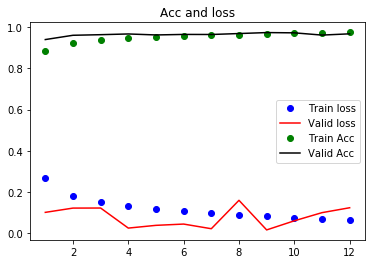

In [18]:
def plot_acc():
    hist_dict=hist.history
    
    train_acc=hist_dict["accuracy"]
    valid_acc=hist_dict["val_accuracy"]
    train_loss=hist_dict["loss"]
    valid_loss=hist_dict["val_loss"]
    
    epoch=range(1,len(train_acc)+1)
    
    #ploting loss and accuracy
    #plot loss
    plt.plot(epoch, train_loss, "bo", label="Train loss")
    plt.plot(epoch, valid_loss, "r", label="Valid loss")
    
    #plot accuracy
    plt.plot(epoch, train_acc, "go", label="Train Acc")
    plt.plot(epoch, valid_acc, "black", label="Valid Acc")
    
    plt.title("Acc and loss")
    plt.legend(loc="best")
    plt.show()

plot_acc()

### Test Prediction

In [21]:
predict=model2.predict(TestX).ravel()
submission=pd.DataFrame({"id": ids, "label": predict})
submission.to_csv("sub01_cov2d_32641282561024512_5.csv", index=False)